# Testing PyTorch Dataset

In [1]:
import torch
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.PILToTensor(),
     transforms.ConvertImageDtype(torch.float)
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [2]:
from SineGratesDataset import SineGrates

In [3]:
trainset = SineGrates(cat_scheme='ii', length=1000, transform=transform)
testset = SineGrates(cat_scheme='ii', length=100, transform=transform)

In [4]:
label, image = next(iter(trainset))

In [5]:
image[0,100]

tensor([0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020,
        0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020, 0.5020,
        0.5020, 0.5020, 0.5020, 0.4941, 0.4392, 0.2980, 0.1294, 0.0784, 0.1216,
        0.2078, 0.3098, 0.4235, 0.5373, 0.6510, 0.7569, 0.8471, 0.9216, 0.9725,
        0.9961, 0.9922, 0.9647, 0.9098, 0.8353, 0.7412, 0.6314, 0.5176, 0.4039,
        0.2902, 0.1922, 0.1098, 0.0510, 0.0118, 0.0039, 0.0196, 0.0627, 0.1255,
        0.2157, 0.3137, 0.4275, 0.5451, 0.6549, 0.7608, 0.8510, 0.9255, 0.9725,
        0.9961, 0.9922, 0.9608, 0.9059, 0.8314, 0.7333, 0.6275, 0.5098, 0.3961,
        0.2863, 0.1882, 0.1059, 0.0471, 0.0118, 0.0039, 0.0196, 0.0627, 0.1294,
        0.2196, 0.3216, 0.4353, 0.5490, 0.6627, 0.7686, 0.8549, 0.9255, 0.9765,
        0.9961, 0.9922, 0.9608, 0.9020, 0.8235, 0.7294, 0.6196, 0.5059, 0.3922,
        0.2824, 0.1843, 0.1020, 0.0431, 0.0118, 0.0039, 0.0235, 0.0667, 0.1333,
        0.2235, 0.3255, 0.4392, 0.5569, 

In [6]:
type(image)

torch.Tensor

# Setting up Data Pipeline

In [7]:
import torch
import torch.nn as nn

In [8]:
batch_size = 32

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=12)

In [10]:
classes = ['Condition A', 'Condition B']

In [11]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

dataiter = iter(trainloader)
labels, images = dataiter.next()

In [12]:
images.shape

torch.Size([32, 1, 256, 256])

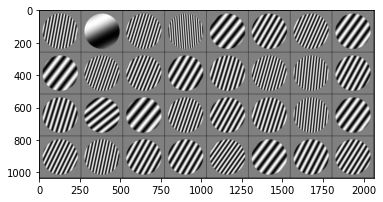

Condition B Condition A Condition B Condition B Condition A Condition A Condition B Condition A Condition A Condition B Condition B Condition A Condition A Condition B Condition B Condition A Condition A Condition B Condition A Condition B Condition A Condition A Condition B Condition A Condition B Condition B Condition A Condition A Condition B Condition A Condition A Condition B


In [13]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Define a Neural Network

In [14]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 2, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [15]:
net = AlexNet()
net = net.cuda()

# Define Loss Function and Optimizer

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [17]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        labels, images = data
        images = 2 * (images - 0.5002) # [0-1] to [-1,1]
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, loss: {running_loss}")
    running_loss = 0.0

Epoch 1, loss: 43.304570496082306
Epoch 2, loss: 26.061141315847635
Epoch 3, loss: 9.44674525782466
Epoch 4, loss: 5.362770802341402
Epoch 5, loss: 5.451218471862376
Epoch 6, loss: 3.515395983471535
Epoch 7, loss: 5.2937982267467305
Epoch 8, loss: 4.218148633372039
Epoch 9, loss: 5.296236668731581
Epoch 10, loss: 3.1100806479225866


ii
```
Epoch 1, loss: 85.18336582183838
Epoch 2, loss: 34.31419908697717
Epoch 3, loss: 20.531744883628562
Epoch 4, loss: 10.242627459112555
Epoch 5, loss: 8.574068777030334
Epoch 6, loss: 6.0638184630115575
Epoch 7, loss: 6.023264018360351
Epoch 8, loss: 5.1939516832790105
Epoch 9, loss: 5.4007573618218885
Epoch 10, loss: 5.164374641648465
Epoch 11, loss: 3.511080036558269
Epoch 12, loss: 4.276801145038917
Epoch 13, loss: 3.6609255538830894
Epoch 14, loss: 4.6994722907015785
Epoch 15, loss: 4.765986231519491
Epoch 16, loss: 4.714876491774248
Epoch 17, loss: 4.739646985006402
Epoch 18, loss: 3.8179756865556556
Epoch 19, loss: 3.849432604794856
Epoch 20, loss: 4.121982953985935
Epoch 21, loss: 3.3283890375539613
Epoch 22, loss: 5.158853088214528
Epoch 23, loss: 3.3509279994996177
Epoch 24, loss: 4.925103814290196
Epoch 25, loss: 3.597546736024924
Epoch 26, loss: 3.4156451058997845
Epoch 27, loss: 3.92656532269757
Epoch 28, loss: 3.454477835464786
Epoch 29, loss: 4.126161962380138
```

rb
```
Epoch 1, loss: 81.22609773278236
Epoch 2, loss: 14.698232750408351
Epoch 3, loss: 7.9504072612617165
Epoch 4, loss: 5.531502670957707
Epoch 5, loss: 2.597533548818319
Epoch 6, loss: 3.287875532914768
Epoch 7, loss: 1.6578662709071068
Epoch 8, loss: 2.9465451682626735
Epoch 9, loss: 3.038850345830724
Epoch 10, loss: 1.9624634058345691
Epoch 11, loss: 2.759255254357413
Epoch 12, loss: 2.156060866313055
Epoch 13, loss: 2.234694680584653
Epoch 14, loss: 2.082504246973258
Epoch 15, loss: 2.892491750237241
Epoch 16, loss: 2.1645498814541497
Epoch 17, loss: 2.2291575001727324
Epoch 18, loss: 1.7113196223872364
Epoch 19, loss: 1.599599110239069
Epoch 20, loss: 1.6463019263683236
Epoch 21, loss: 1.765304080741771
Epoch 22, loss: 2.0521400574434665
Epoch 23, loss: 2.256082821975724
Epoch 24, loss: 2.027793706598459
Epoch 25, loss: 1.510054058764581
Epoch 26, loss: 1.9244091983491671
Epoch 27, loss: 1.6030073140500463
Epoch 28, loss: 1.3176469673635438
Epoch 29, loss: 1.6648579663578857
```

In [18]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=12)
dataiter = iter(testloader)
labels, images = dataiter.next()

images.shape

torch.Size([32, 1, 256, 256])

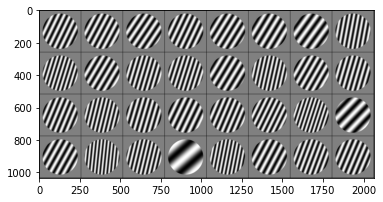

GroundTruth:  Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A Condition A


In [19]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [20]:
outputs = net(images.cuda())

In [21]:
outputs

tensor([[ 2.7921, -2.7133],
        [ 2.9190, -2.8478],
        [ 2.5120, -2.4980],
        [ 2.8757, -2.7496],
        [ 2.4412, -2.4048],
        [ 2.7266, -2.6959],
        [ 2.5540, -2.4985],
        [ 2.9804, -3.0088],
        [ 2.1008, -2.0973],
        [ 2.8863, -2.8071],
        [ 2.8593, -2.7565],
        [ 2.4475, -2.4308],
        [ 2.9024, -2.8248],
        [ 2.6678, -2.6475],
        [ 2.5098, -2.5185],
        [ 3.4115, -3.3749],
        [ 2.6595, -2.6337],
        [ 2.8112, -2.7293],
        [ 3.2594, -3.2339],
        [ 3.1438, -3.1273],
        [ 3.0534, -2.9599],
        [ 2.6039, -2.5612],
        [ 1.4819, -1.4725],
        [ 2.1561, -2.1151],
        [ 2.6671, -2.6598],
        [ 2.0704, -2.0087],
        [ 2.3334, -2.3308],
        [ 1.9272, -1.9275],
        [ 2.1981, -2.1608],
        [ 3.3890, -3.3034],
        [ 3.0091, -2.9678],
        [ 2.9993, -2.8724]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
import torch.nn.functional as F

In [23]:
softmax_labels = F.log_softmax(outputs, dim=1)

In [24]:
softmax_labels

tensor([[-4.0563e-03, -5.5095e+00],
        [-3.1250e-03, -5.7699e+00],
        [-6.6494e-03, -5.0166e+00],
        [-3.5990e-03, -5.6289e+00],
        [-7.8287e-03, -4.8539e+00],
        [-4.4060e-03, -5.4270e+00],
        [-6.3727e-03, -5.0589e+00],
        [-2.5025e-03, -5.9917e+00],
        [-1.4912e-02, -4.2131e+00],
        [-3.3622e-03, -5.6968e+00],
        [-3.6333e-03, -5.6194e+00],
        [-7.5810e-03, -4.8859e+00],
        [-3.2511e-03, -5.7304e+00],
        [-4.9039e-03, -5.3202e+00],
        [-6.5285e-03, -5.0348e+00],
        [-1.1284e-03, -6.7875e+00],
        [-5.0129e-03, -5.2983e+00],
        [-3.9169e-03, -5.5444e+00],
        [-1.5125e-03, -6.4948e+00],
        [-1.8883e-03, -6.2730e+00],
        [-2.4429e-03, -6.0158e+00],
        [-5.6963e-03, -5.1708e+00],
        [-5.0797e-02, -3.0052e+00],
        [-1.3869e-02, -4.2850e+00],
        [-4.8472e-03, -5.3318e+00],
        [-1.6783e-02, -4.0958e+00],
        [-9.3831e-03, -4.6735e+00],
        [-2.0959e-02, -3.875

In [25]:
preds_classes = torch.argmax(softmax_labels, axis=-1)

In [26]:
preds_classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')